In [1]:
# 필요한 라이브러리를 import하기

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

import os
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# MNIST 데이터셋을 이용할 것이다
# 데이터를 다운로드할 경로 변수를 지정한다

# exist_ok라는 파라미터를 True로 하면 해당 디렉토리가 기존에 존재하면 에러발생 없이 넘어가고, 없을 경우에만 생성
# 반대로, exist_ok를 True로 설정하지 않았을 때 이미 해당 디렉토리가 존재하는 경우에는 exception에러가 뜨게 된다.

path2data = "./data"
os.makedirs(path2data, exist_ok=True)

In [3]:
# MNIST 데이터셋을 불러오고 데이터 전처리 Pre-processor를 구현한다
train_ds = datasets.MNIST(path2data, train=True, transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]), download=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



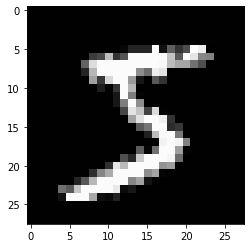

In [7]:
# 샘플 이미지를 한번 출력해보자
img, label = train_ds[0]

# Pytorch의 MNIST 데이터셋에서 추출한 이미지 데이터는 Tensor로 이루어져 있다.
# 이 Tensor를 pil image data type으로 변경시켜주는 함수인 to_pil_image를 이용한다
plt.imshow(to_pil_image(img), cmap="gray")

In [8]:
# Dataset을 원하는 batch만큼 한꺼번에 불러올 수 있는 DataLoader를 정의한다
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

# 하나의 batch data의 shape를 확인하기
for x, y in train_dl:
  print(x.shape, y.shape)
  break

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [12]:
# Generator를 구현한다
# Generator는 특정 크기의 noise를 입력받아 이미지를 생성하는 생성자이다
# noise를 입력받아서 (batch_size, 1, 28, 28)형태의 가짜 이미지 데이터를 반환한다
class Generator(nn.Module):
  def __init__(self, params):
    super().__init__()
    self.nz = params['nz'] # 입력 노이즈 벡터 수. 이걸 입력받아 가짜 이미지를 생성하는 것이다
    self.img_size = params['img_size'] # 이미지 크기. 1*28*28

    self.model = nn.Sequential(
        *self._fc_layer(self.nz, 128, normalize=False),
        *self._fc_layer(128,256),
        *self._fc_layer(256,512),
        *self._fc_layer(512,1024),
        nn.Linear(1024, int(np.prod(self.img_size))), # np.prod(1*28*28) = 1*28*28이다
        nn.Tanh()
    )
  
  def forward(self, z):
    img = self.model(z)
    img = img.view(img.size(0), *self.img_size) # (batch_size, 1, 28, 28)형태로 만든다
    return img

  # FC Layer와 Batch normalization, LeakyReLU가 결합된 모델을 일괄적으로 생성하는 함수를 만든다
  def _fc_layer(self, in_channels, out_channels, normalize=True):
    layers = []
    layers.append(nn.Linear(in_channels, out_channels))
    if normalize:
      layers.append(nn.BatchNorm1d(out_channels))
    layers.append(nn.LeakyReLU(0.2))

    return layers

# Generator를 정의하였으니 직접 모델을 만들어서 input을 넣어 test해보자
params = {'nz':100, 'img_size':(1,28,28)}
x = torch.randn(16,100).to(device)
model_gen = Generator(params).to(device)
output = model_gen(x)
print(output.shape)

torch.Size([16, 1, 28, 28])


In [13]:
from matplotlib.pyplot import disconnect
# Discriminator를 정의한다
# 실제 이미지와 가짜 이미지를 분류하는 판별자이다
# (batch_size, 1, 28, 28)형태를 입력받아 (batch_size, 실제일 확률) 값을 반환한다
class Discriminator(nn.Module):
  def __init__(self, params):
    super().__init__()
    self.img_size = params['img_size'] # 이미지 크기 (1,28,28)
    self.model = nn.Sequential(
        nn.Linear(int(np.prod(self.img_size)), 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2),
        nn.Linear(256,1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.model(x)
    return x

# Discriminator를 정의하였으니 직접 모델을 만들어서 input을 넣어 test해보자
x = torch.randn(16,1,28,28).to(device)
model_dis = Discriminator(params).to(device)
output = model_dis(x)
print(output.shape)

torch.Size([16, 1])


In [14]:
# 모델에 적용할 가중치 초기화 함수를 정의한다
def initialize_weights(model):
  classname = model.__class__.__name__

  # 만약 FC Layer라면
  if classname.find("Linear") != -1:
    nn.init.normal_(model.weight.data, 0.0, 0.02)
    nn.init.constant_(model.bias.data,0)
  elif classname.find("BatchNorm") != -1:
    nn.init.normal_(model.weight.data, 1.0, 0.02)
    nn.init.constant_(model.bias.data,0)

# Generator, Discriminator모델에 가중치 초기화 함수를 적용한다
model_gen.apply(initialize_weights)
model_dis.apply(initialize_weights)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [16]:
# 손실함수를 정의한다
loss_func = nn.BCELoss()

from torch import optim

# 생성자와 판별자의 optimizer를 생성한다
opt_dis = optim.Adam(model_dis.parameters(), lr=2e-4)
opt_gen = optim.Adam(model_gen.parameters(), lr=2e-4)

In [18]:
# 학습에 사용될 여러 변수를 정의한다
real_label = 1.   # 실제 이미지의 라벨
fake_label = 0.   # 가짜이미지의 라벨
nz = params['nz'] # 입력벡터의 차원
num_epochs = 100

loss_history = {'gen':[], 'dis':[]} # 생성자와 판별자의 epoch별 손실함수값 저장

In [19]:
# 본격적으로 학습을 위한 code를 작성하자
batch_count = 0
start_time = time.time()

# 생성자와 판별자를 Train Mode로 설정하고 학습을 시작한다
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
  for xb, yb in train_dl:
    batch_size = xb.size(0)

    xb = xb.to(device)
    yb_real = torch.Tensor(batch_size, 1).fill_(1.0).to(device) # 실제 이미지의 정답 Label
    yb_fake = torch.Tensor(batch_size, 1).fill_(0.0).to(device) # 가짜 이미지의 정답 Label

    # Generator를 먼저 학습한다
    # Generator가 생성한 이미지를 Discriminator가 진짜로 판별하도록 생성자를 훈련해야 한다
    model_gen.zero_grad()
    noise = torch.randn(batch_size, nz, device=device) # 노이즈 벡터 생성
    out_gen = model_gen(noise) # 노이즈 벡터로 가짜 이미지를 생성한다
    out_dis = model_dis(out_gen) # 판별자는 생성된 가짜 이미지를 판별한다

    # 생성된 가짜 이미지를 실제 이미지로 판별하게끔 유도된 가중치 미분값을 전달하는 과정이다
    loss_gen = loss_func(out_dis, yb_real)
    loss_gen.backward()
    opt_gen.step()

    # Generator를 학습 완료하였으므로
    # 이제는 Discriminator의 학습을 할 순서이다
    model_dis.zero_grad()

    out_real = model_dis(xb) # 실제 이미지를 판별한 결과
    out_fake = model_dis(out_gen.detach()) # 가짜 이미지를 판별한 결과 Generator는 학습을 완료했으므로 가중치 미분 계산이 필요 없는 것은 하지 않는다
    loss_real = loss_func(out_real, yb_real) # 실제 이미지는 모두 1로 판별하도록
    loss_fake = loss_func(out_fake, yb_fake) # 가짜 이미지는 모두 0으로 판별하도록
    loss_dis = (loss_real + loss_fake) / 2 # 평균

    loss_dis.backward()
    opt_dis.step()

    loss_history['gen'].append(loss_gen.item())
    loss_history['dis'].append(loss_dis.item())

    batch_count += 1
    # 1000개의 Batch Dataset마다 학습 현황을 출력한다
    if batch_count % 1000 == 0:
      print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))


Epoch: 0, G_Loss: 5.459488, D_Loss: 0.153596, time: 0.19 min
Epoch: 1, G_Loss: 7.567792, D_Loss: 0.030353, time: 0.38 min
Epoch: 1, G_Loss: 1.935759, D_Loss: 0.226041, time: 0.57 min
Epoch: 2, G_Loss: 4.475760, D_Loss: 0.159298, time: 0.76 min
Epoch: 2, G_Loss: 2.289071, D_Loss: 0.113047, time: 0.94 min
Epoch: 3, G_Loss: 3.053017, D_Loss: 0.101146, time: 1.13 min
Epoch: 3, G_Loss: 1.250765, D_Loss: 0.338673, time: 1.32 min
Epoch: 4, G_Loss: 1.303463, D_Loss: 0.415278, time: 1.51 min
Epoch: 4, G_Loss: 2.889182, D_Loss: 0.238691, time: 1.70 min
Epoch: 5, G_Loss: 1.946798, D_Loss: 0.318085, time: 1.89 min
Epoch: 5, G_Loss: 2.451798, D_Loss: 0.169655, time: 2.07 min
Epoch: 6, G_Loss: 2.595397, D_Loss: 0.230782, time: 2.26 min
Epoch: 6, G_Loss: 1.095328, D_Loss: 0.660779, time: 2.45 min
Epoch: 7, G_Loss: 2.112707, D_Loss: 0.216565, time: 2.64 min
Epoch: 7, G_Loss: 1.957702, D_Loss: 0.413064, time: 2.83 min
Epoch: 8, G_Loss: 2.893557, D_Loss: 0.421148, time: 3.01 min
Epoch: 9, G_Loss: 2.3980

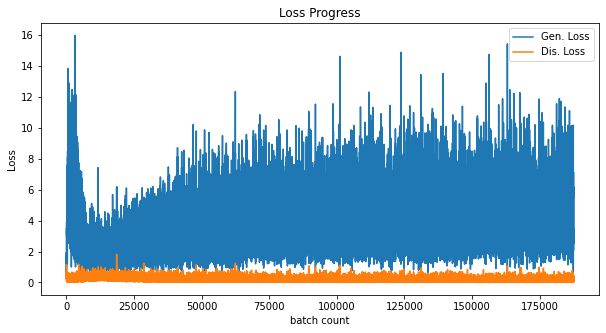

In [20]:
# 100 Epoch 학습을 완료하였다.
# 100 Epoch동안의 손실함수 진행상황을 출력해보자
plt.figure(figsize=(10,5))
plt.title("Loss Progress")
plt.plot(loss_history['gen'], label="Gen. Loss")
plt.plot(loss_history['dis'], label="Dis. Loss")
plt.xlabel("batch count")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
# 학습된 모델의 가중치를 저장하자
path2models = "./models"
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, "weights_gen.pt")
path2weights_dis = os.path.join(path2models, "weights_dis.pt")

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [23]:
# 가중치를 불러오고 Generator에 적용시킨 후 
# Generator가 얼마나 정확한 이미지를 생성해내는지 확인해보자

weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# Generator에 Evaluation Mode적용하기
model_gen.eval()

# 16개의 Fake Image를 생성해보자
with torch.no_grad():
  fixed_noise = torch.randn(16,100, device=device)
  img_fake = model_gen(fixed_noise).cpu()
print(img_fake.shape)

torch.Size([16, 1, 28, 28])


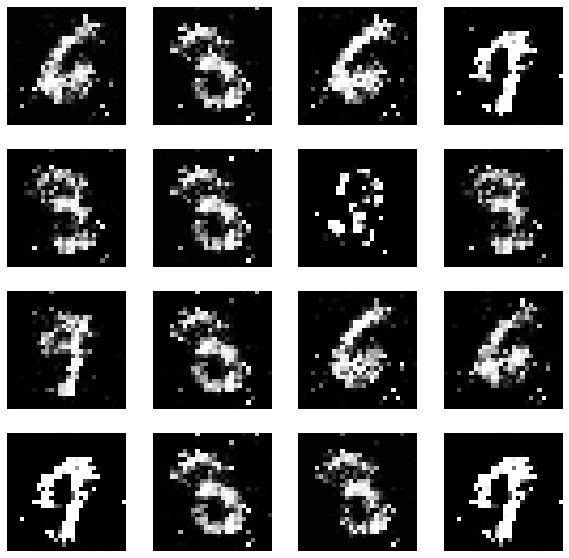

In [26]:
# 가짜 이미지를 시각화해보자
plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(to_pil_image(img_fake[i]), cmap='gray')
  plt.axis('off')